In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.ndimage import gaussian_filter
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_SRTR"): print("\nThe data folder \"_data_SRTR\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_SRTR/"); 
    path_data = path_notebook + "/_data_SRTR/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})

t_compare, aofe_compare, _, aad_compare, _ = lib2.load_pkl(path_notebook + f"/error_progressions/error_progression_long_inve.pkl")


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/


In [4]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2); pass

## Invernizzi Potential

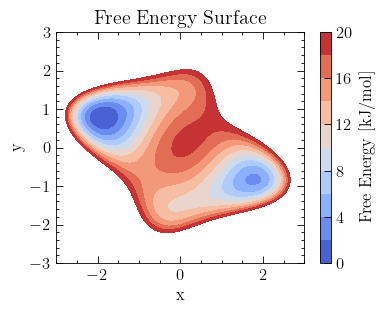

In [56]:
# Define plumed grid
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

for _inve_pot_ in [1]:
    # Define the grid, the potential, the string of the potential and the FES cutoff

    inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
    inve_pot = inve_pot - np.min(inve_pot)
    inve_pot_string = "1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598"
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({inve_pot_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    FES_cutoff = 20
    # plot the free energy surface
    plt.contourf(X, Y, inve_pot, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Free Energy Surface"); plt.show()

    # Stimulation path
    path_invernizzi = path_data + "Invernizzi_Potential/"
    path_surf = path_data + "Invernizzi_Potential/"

    # default parameters for the MFI class
    default_params = {  "X":X, "Y":Y, "Z":inve_pot, 
                        "bw":[0.1, 0.1], "System":"Langevin", "plumed_dat_text":plumed_dat_text, 
                        "position_pace":20, "n_pos_per_window":10, "metad_pace":200,
                        "Bias_sf":1.03, "gaus_filter_sigma":1, 
                        "FES_cutoff":FES_cutoff, "bootstrap_iter":20,
                        "simulation_folder_path": path_invernizzi, "print_info":True,
                        }
    
for _pot_2_ in [2]:
    
    grid = np.linspace(-3, 3, 200); 
    X, Y = np.meshgrid(gridx, gridy)
    [plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

    
    pot2 = 1.84*X**6 + 1.84*Y**6 - 11.5*X**4 - 11.5*Y**4 + 17.94*X**2 + 17.94*Y**2 - 2.3*X**5*Y + 2.3*X*Y**5 - 3.7*X**3*Y + 3.7*X*Y**3 + 20*X**2*Y**2 + 2.1*X**2 + 2.1*Y**2 + X**2*Y + X*Y**2 + 24.70075155
    pot2 = pot2 - np.min(pot2)
    pot2_string = "1.84*x^6+1.84*y^6-11.5*x^4-11.5*y^4+17.94*x^2+17.94*y^2-2.3*x^5*y+2.3*x*y^5-3.7*x^3*y+3.7*x*y^3+20*x^2*y^2+2.1*x^2+2.1*y^2+x^2*y+x*y^2+24.70075155"
 
    plumed_dat_text_pot2 = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot2_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    path_pot2 = path_data + "pot2/"
    FES_cutoff = 40
    sim_var_pot2 = 3_000_000, 0.1, 2, 20, 40
    
    # default parameters for the MFI class
    default_params = {  "X":X, "Y":Y, "Z":pot2, 
                        "bw":[0.1, 0.1], "System":"Langevin", "plumed_dat_text":plumed_dat_text_pot2, 
                        "position_pace":20, "n_pos_per_window":10, "metad_pace":200,
                        "Bias_sf":1.0, "gaus_filter_sigma":2, 
                        "FES_cutoff":FES_cutoff, "bootstrap_iter":20, "record_maps":True,
                        "simulation_folder_path": path_pot2, "print_info":True,
                        }

In [47]:
print(np.sum(pot2_check - pot2))

0.0


### MFI2D run SRTR

~~ S1  START ~~~
~~ S1  PHASE: exploration ~~~  | MetaD h= 8.0 , w= [0.15,0.175] , bf= 200 | 
S 1 | t= 0.18ns | t_tot= 0.18ns | n_pos: 1760/ 1760 : Aofe: 11.95 | AAD: 58.21
S 1 END | t= 0.38ns | t_tot= 0.38ns | n_pos: 3760/ 3760 : Aofe: 6.920 | AAD: 3.495 | ABS: 2.771 | Reason for termination: Exploration stage completed
~~ S2  START ~~~
~~ S2  PHASE: metad ~~~  | MetaD h= 3.67 , w= [0.12,0.14] , bf= 11 | InvF Bias sf= 1.0, guas sigma = 2 | 
S 2 | t= 0.10ns | t_tot= 0.48ns | n_pos: 1010/ 4770 : Aofe: 5.985 | AAD: 3.729 | ABS: 2.349 
S 2 | t= 0.20ns | t_tot= 0.58ns | n_pos: 1000/ 5770 : Aofe: 5.287 | AAD: 3.511 | ABS: 2.482 
S 2 | t= 0.33ns | t_tot= 0.70ns | n_pos: 1250/ 7020 : Aofe: 4.656 | AAD: 3.293 | ABS: 2.069 
S 2 | t= 0.45ns | t_tot= 0.83ns | n_pos: 1250/ 8270 : Aofe: 4.218 | AAD: 3.331 | ABS: 2.012 
S 2 | t= 0.60ns | t_tot= 0.98ns | n_pos: 1490/ 9760 : Aofe: 3.745 | AAD: 2.751 | ABS: 1.582 
S 2 | t= 0.75ns | t_tot= 1.13ns | n_pos: 1500/11260 : Aofe: 3.445 | AAD: 2.964 | ABS: 1.5

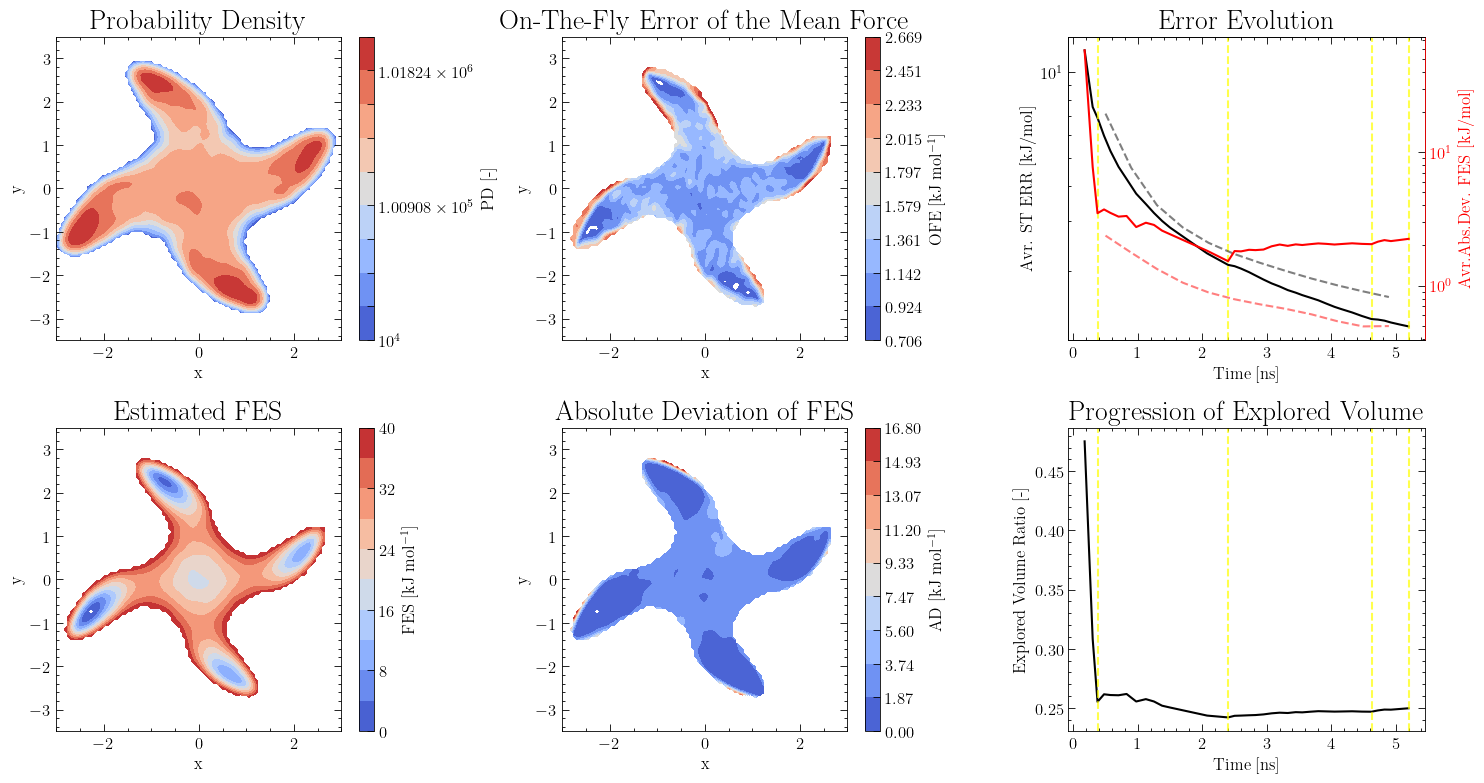


~~~~~~ END ~~~~~~

MFI.Aofe = 1.2791, MFI.AAD = 2.2437


In [57]:
MFI = MFI_class2D.MFI2D(**default_params)

MFI.MFI_real_time_ReInit(ID="_test2", goal=0.1, main_error_type="ST_ERR", n_pos_before_analysis=1000, guaranteed_sim_time=2, max_sim_time=5,
                         time_budget=5)
                        #  restart_SRTR=True, time_budget=80)

MFI.plot_results(t_compare=t_compare, aofe_compare=aofe_compare, aad_compare=aad_compare)

print(f"\n~~~~~~ END ~~~~~~\n\n{MFI.Aofe = :.4f}", end=""); print(f", {MFI.AAD = :.4f}") if MFI.Z is not None else print("")

Reloading existing SRTR Campaign
Found 4 existing simulation folders
Ignoring the first 2 simulation folders
Loading simulation folder: simulation_test2_1 - using existing force terms.
Loading simulation folder: simulation_test2_2 - using existing force terms.
Loading simulation folder: simulation_test2_3 - using existing force terms.
Loading simulation folder: simulation_test2_4 - using existing force terms.

Reloaded SRTR campaign with 4 existing simulations and 5.1280 ns existing simulation time.
Aofe = 1.092 | AAD = 1.619 | ABS = nan | 
SRTR campaign reloaded. No new simulations will be started.



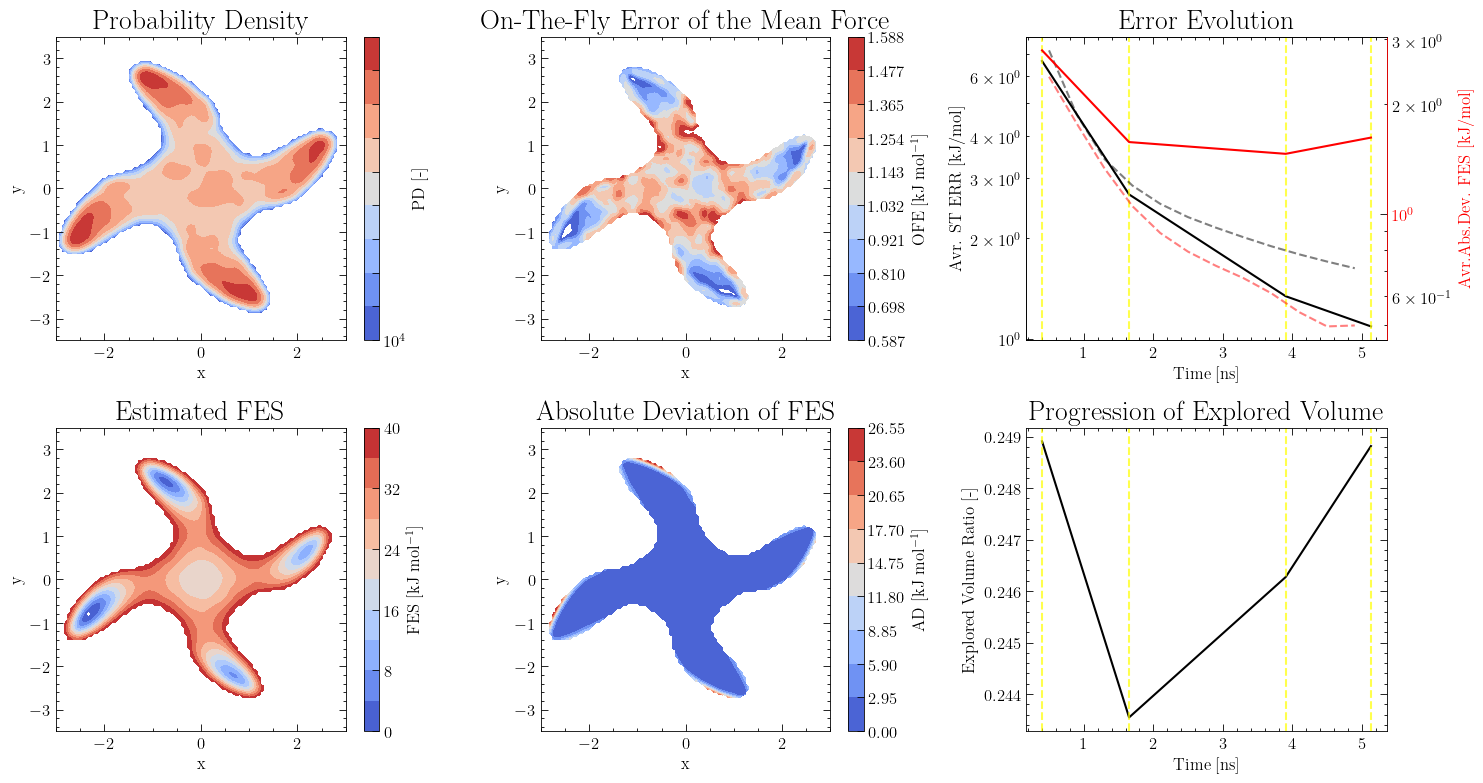


~~~~~~ END ~~~~~~

MFI.Aofe = 1.0916, MFI.AAD = 1.6187


In [36]:
MFI = MFI_class2D.MFI2D(**default_params)

MFI.MFI_real_time_ReInit(ID="_test2", goal=0.1, main_error_type="ST_ERR", n_pos_before_analysis=1000, guaranteed_sim_time=2, max_sim_time=5,
                        #  time_budget=5)
                         restart_SRTR="reload_ignore_2", time_budget=80)

MFI.plot_results(t_compare=t_compare, aofe_compare=aofe_compare, aad_compare=aad_compare)

print(f"\n~~~~~~ END ~~~~~~\n\n{MFI.Aofe = :.4f}", end=""); print(f", {MFI.AAD = :.4f}") if MFI.Z is not None else print("")

In [42]:
ns = 4
h, p = lib2.read_data(hills_path = f"simulation_test2_{ns}/HILLS_test2_{ns}", pos_path = f"simulation_test2_{ns}/position_test2_{ns}")

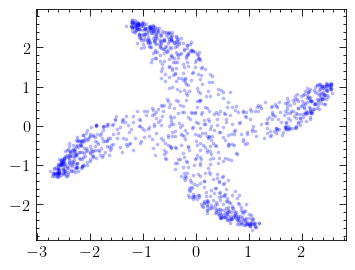

In [43]:
plt.scatter(h[:,1], h[:,2], s=3, c="blue", alpha=0.2)

In [71]:
MFI.Avr_Error_list[-1]

MFI.n_pos_analysed

3760+20250+22250+5760

52020

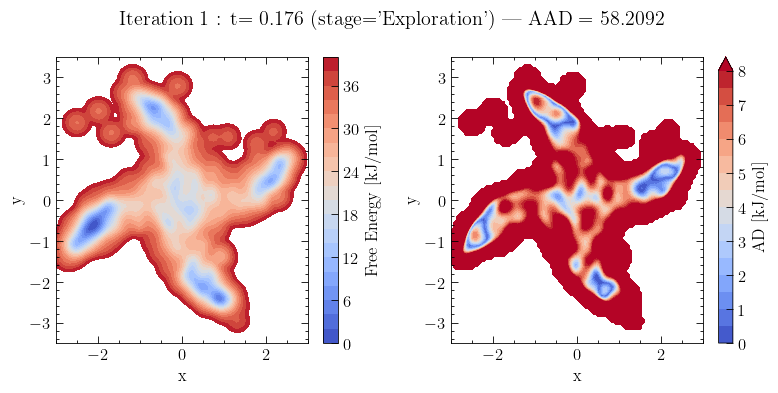

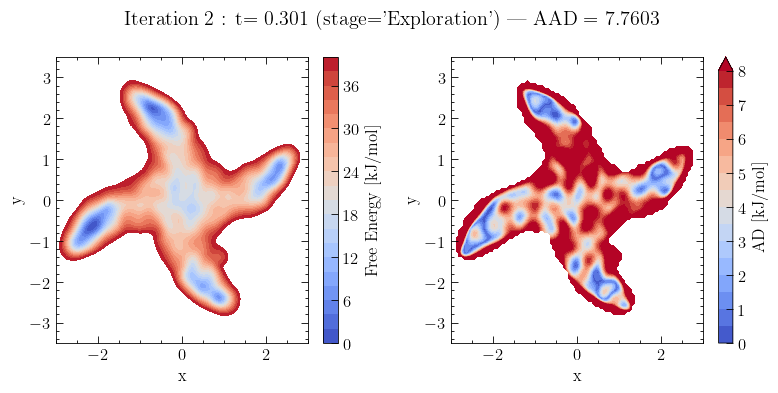

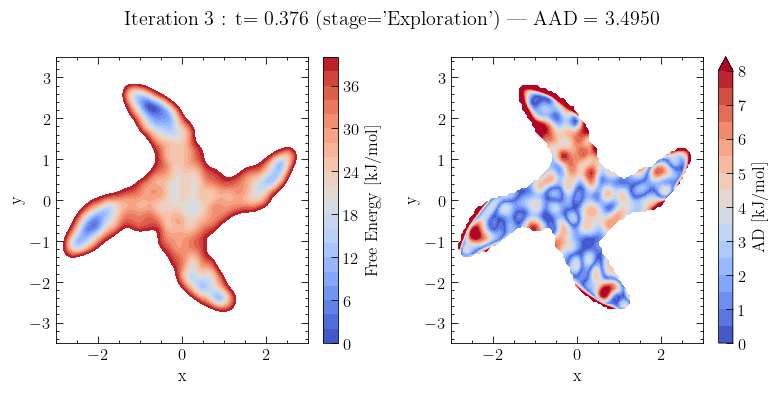

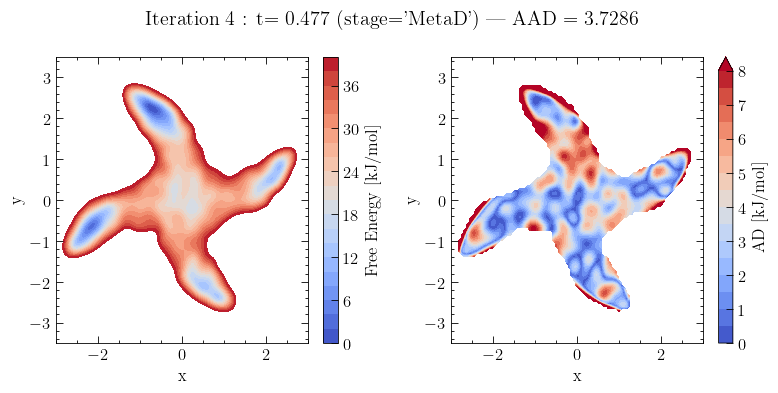

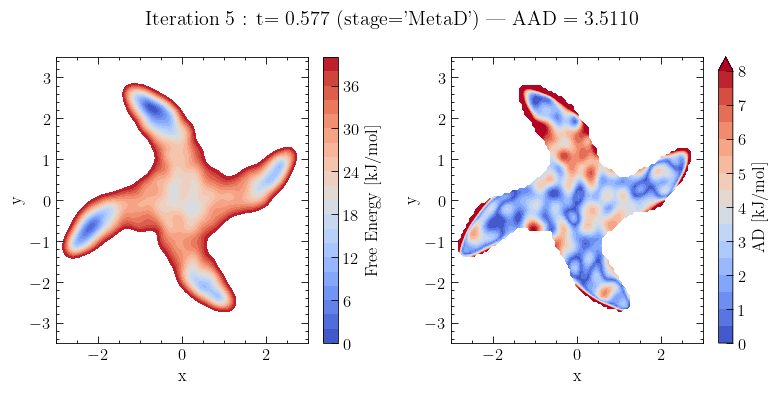

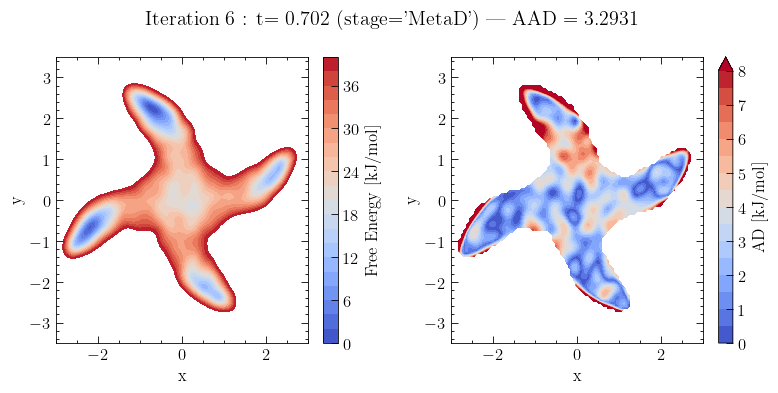

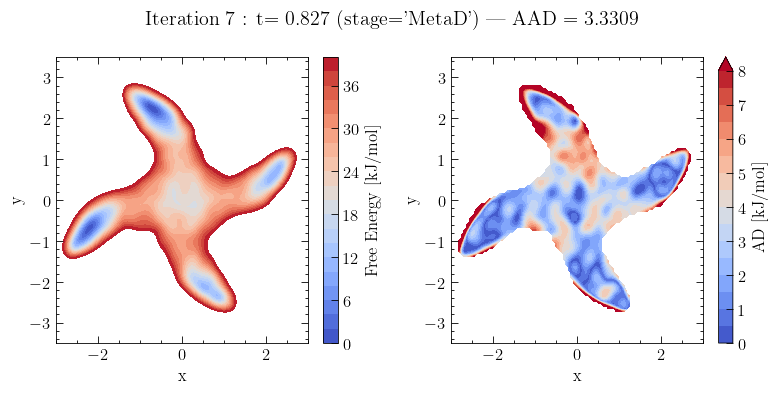

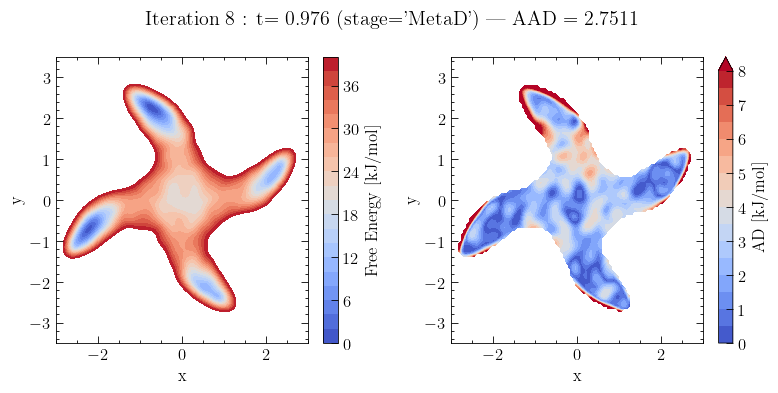

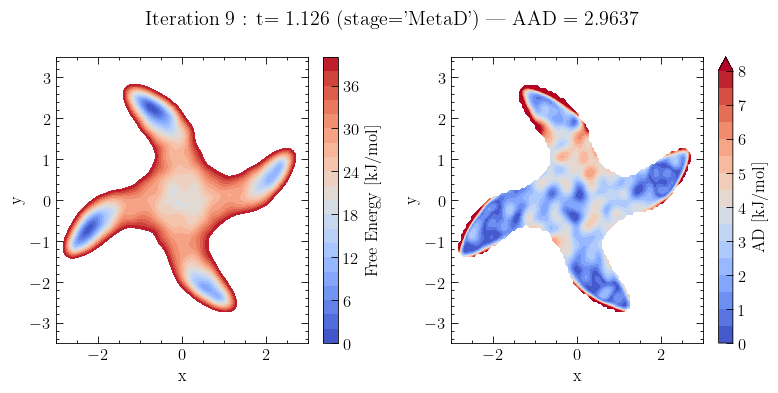

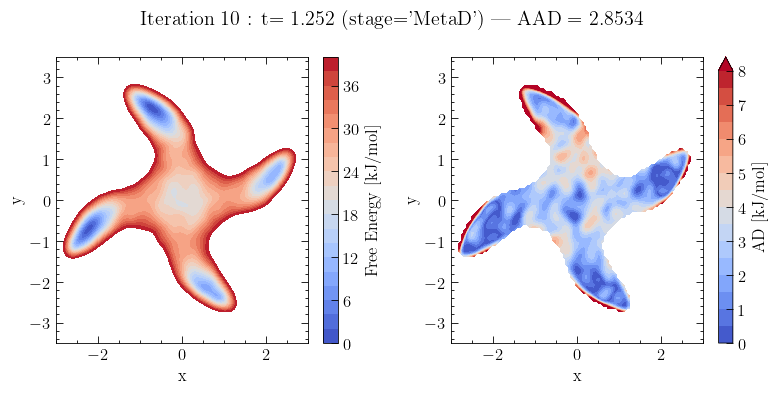

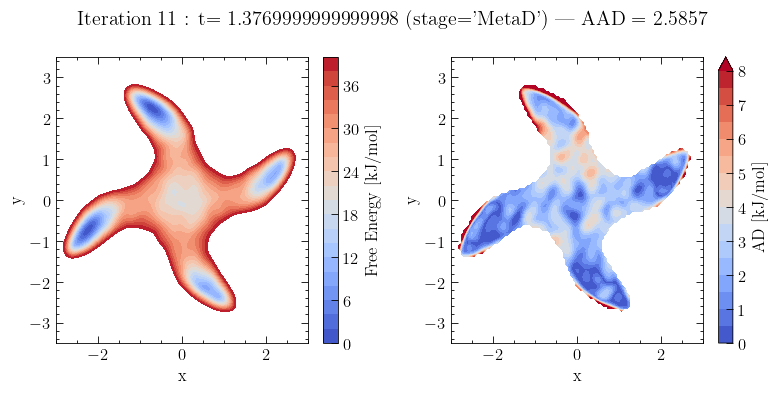

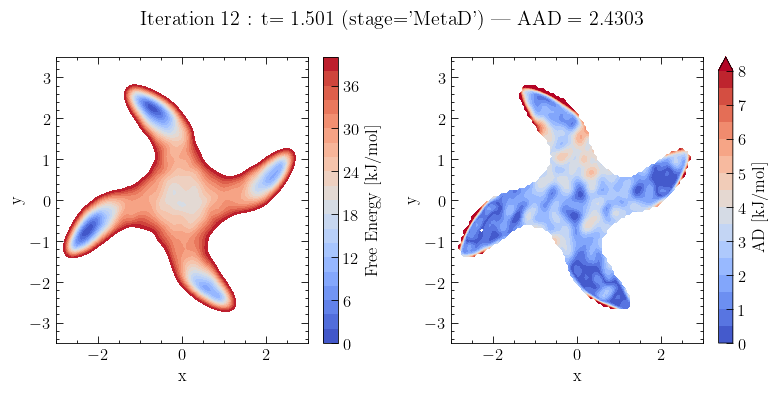

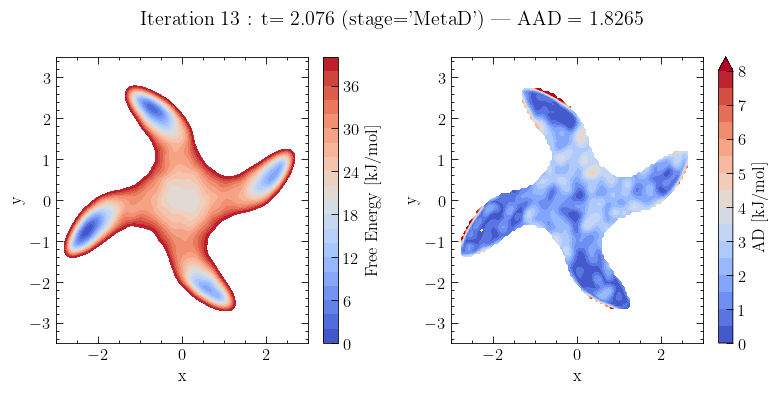

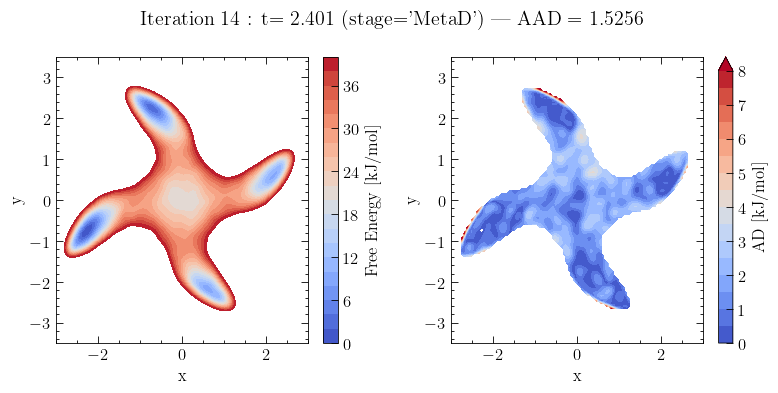

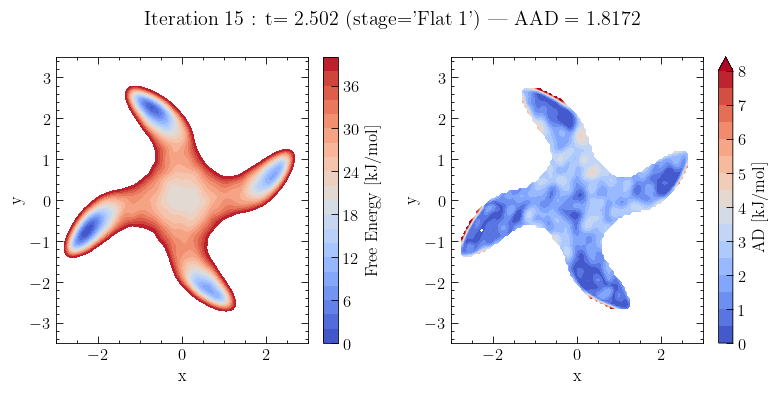

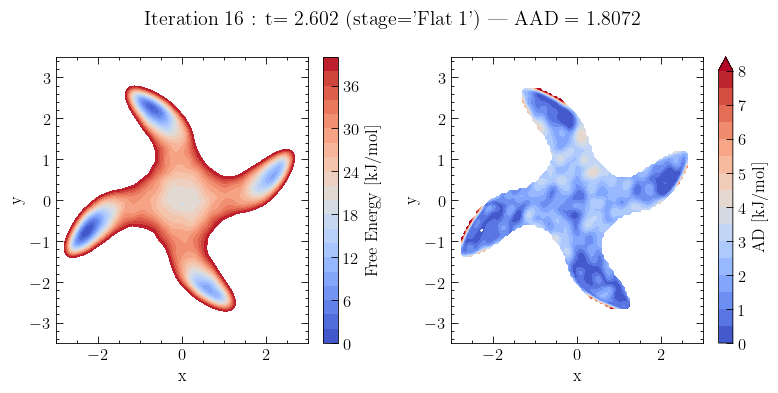

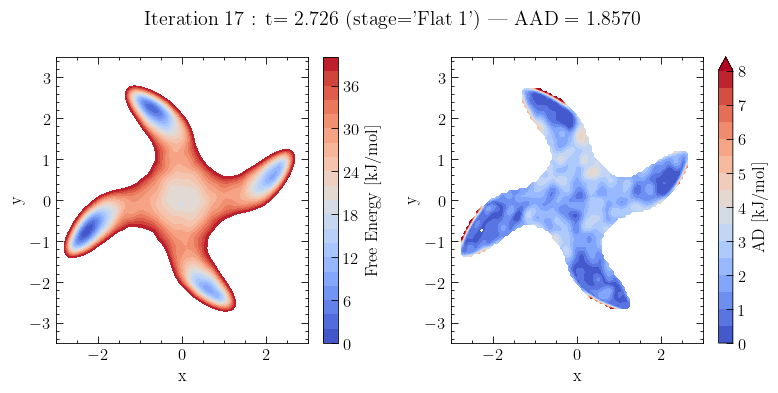

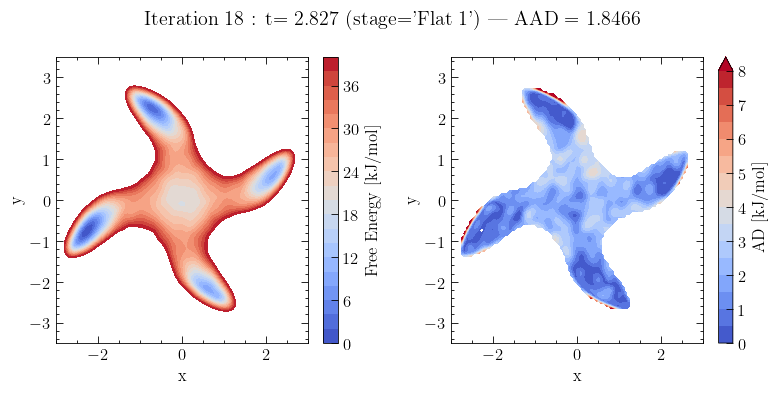

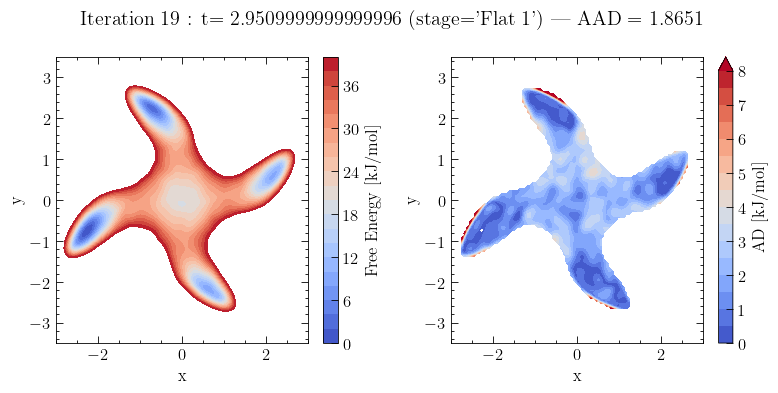

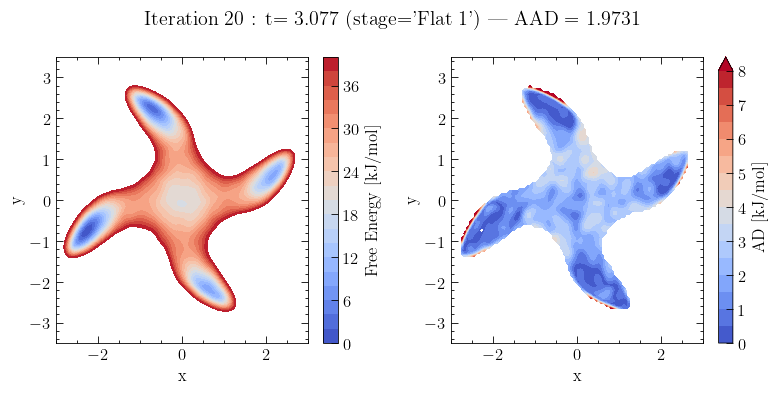

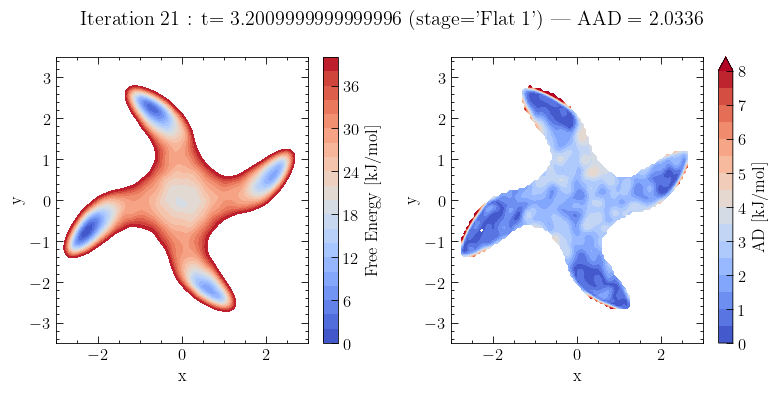

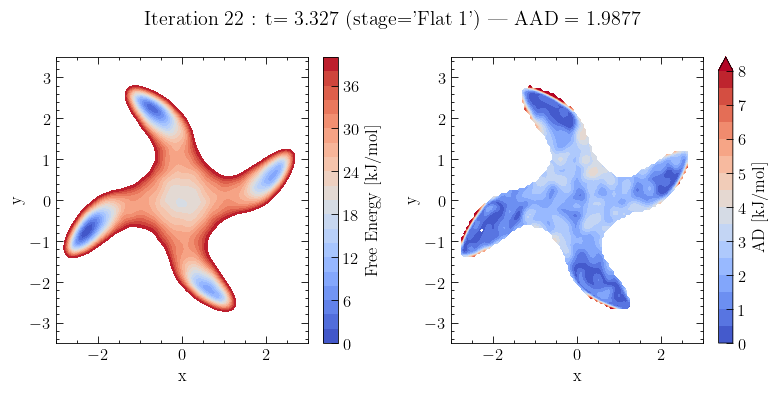

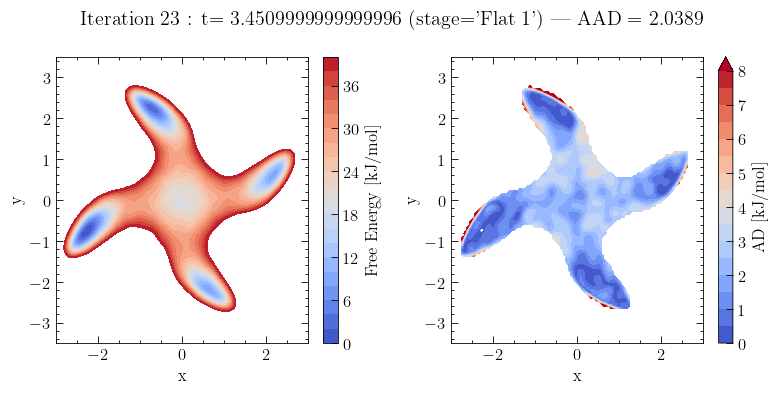

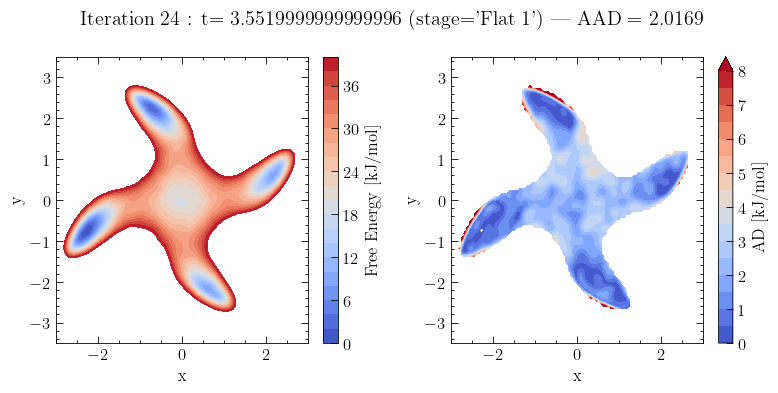

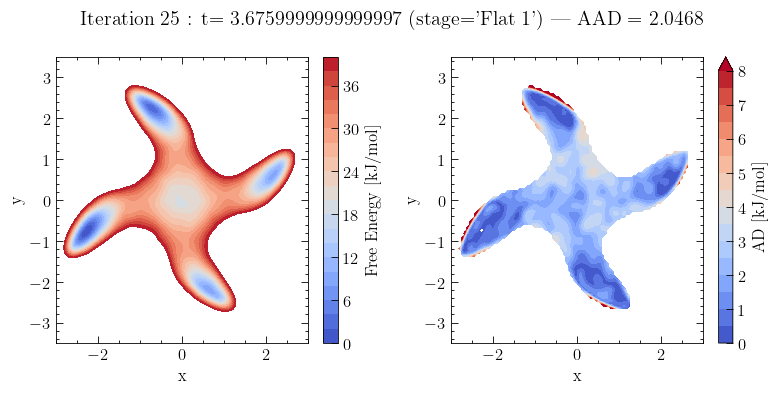

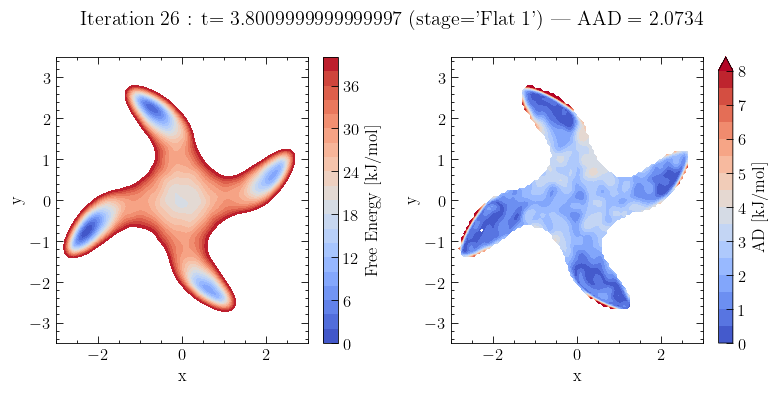

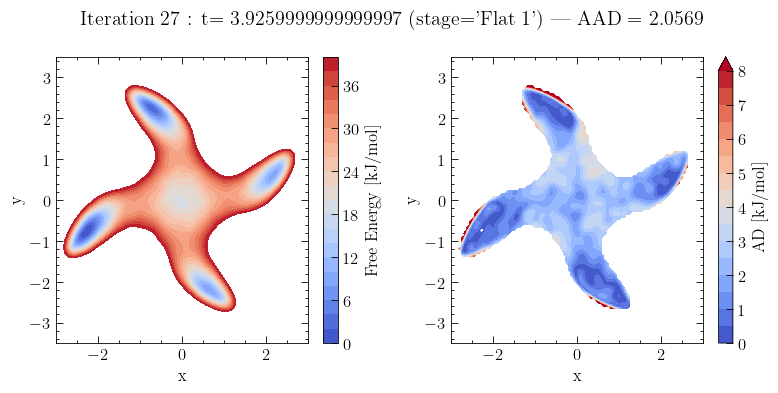

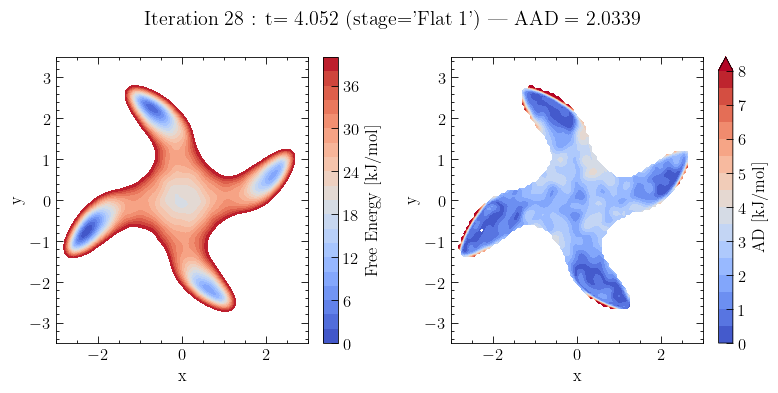

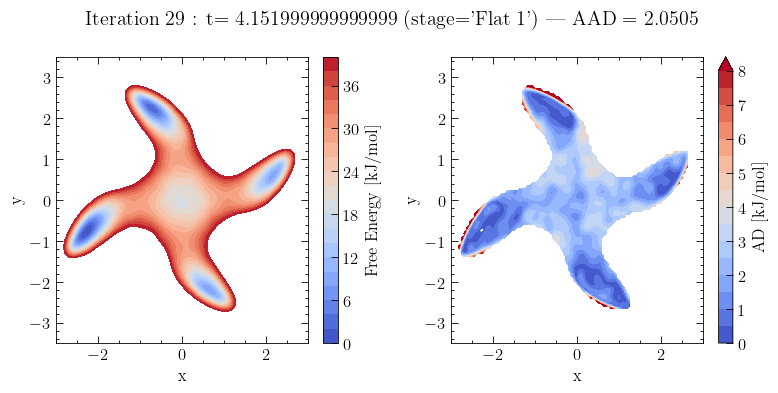

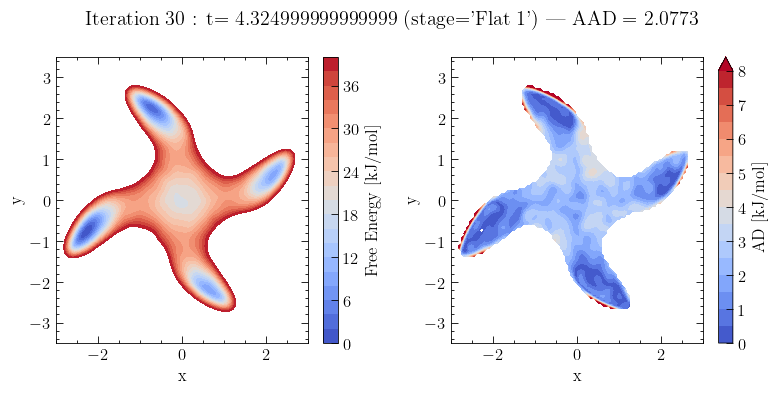

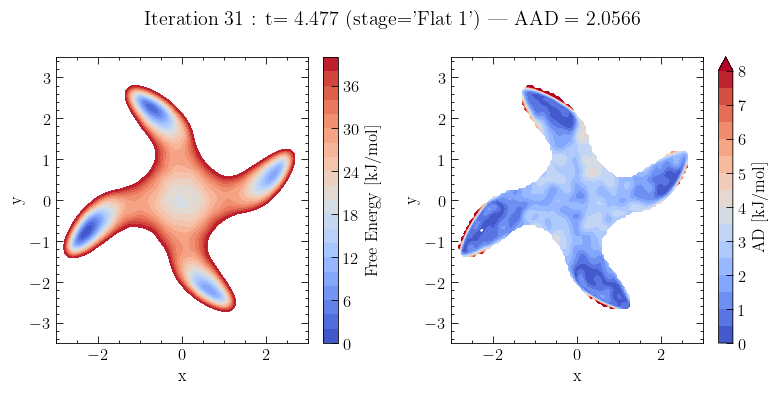

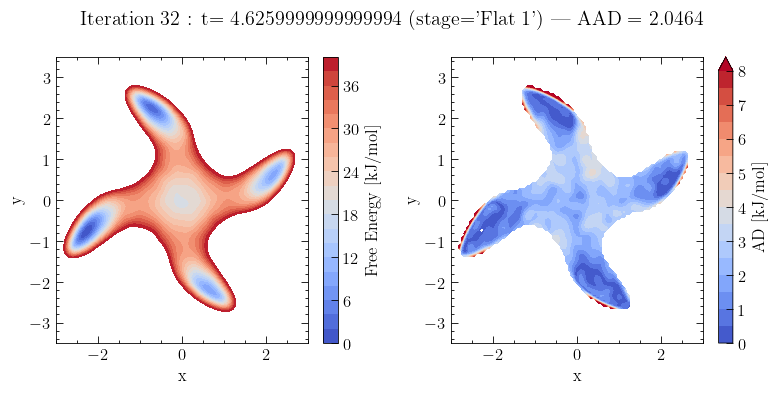

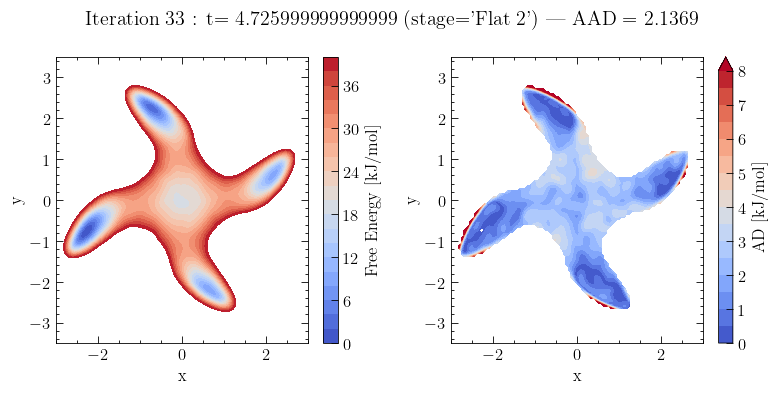

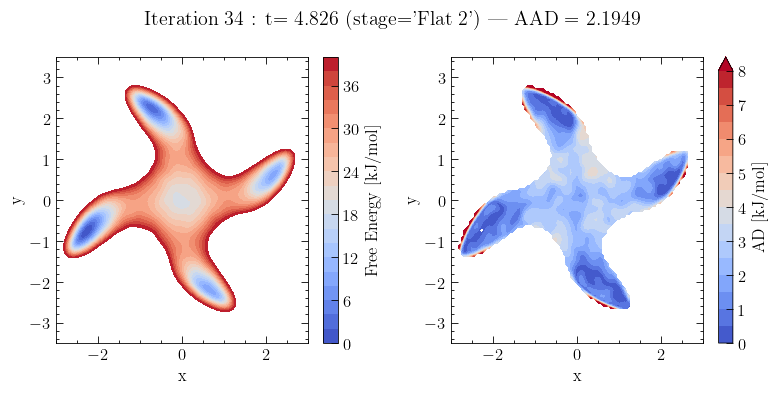

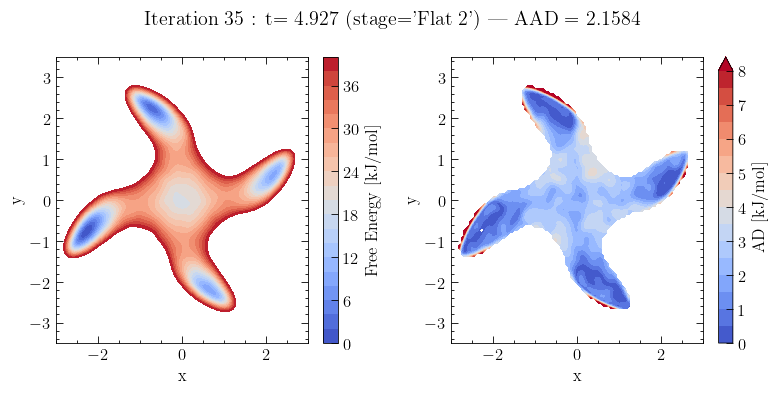

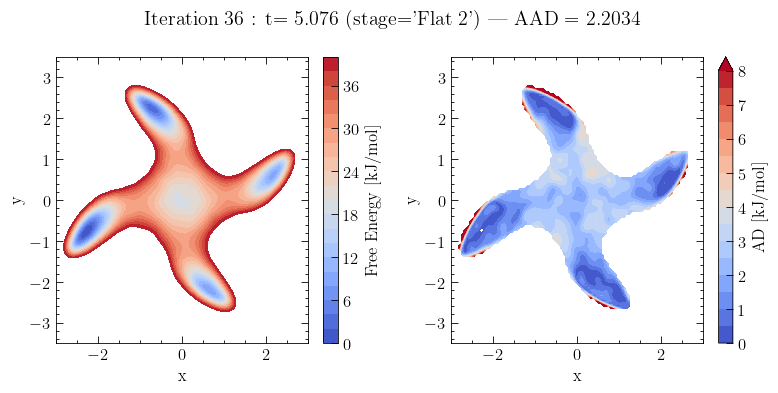

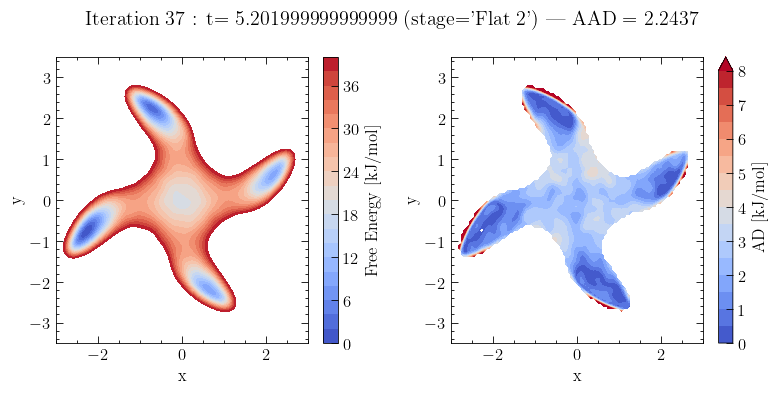

In [74]:
stage = "Exploration"
stage_npos = [3760, 3760+20250, 3760+20250+22250, 3760+20250+22250+5760]

for i in range(len(MFI.Maps_list)):
    
    if MFI.Avr_Error_list[i,0]*10000 > stage_npos[0]: stage = "MetaD"
    if MFI.Avr_Error_list[i,0]*10000 > stage_npos[1]: stage = "Flat 1"
    if MFI.Avr_Error_list[i,0]*10000 > stage_npos[2]: stage = "Flat 2"
    
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    plt.contourf(X, Y, MFI.Maps_list[i,0], levels=np.linspace(0, 40 , 21), cmap='coolwarm'); 
    plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); 
    
    plt.subplot(1,2,2)
    plt.contourf(X, Y, lib2.zero_to_nan(MFI.Maps_list[i,-2]), levels=np.linspace(0, 8 , 17), cmap='coolwarm', extend="max");
    plt.colorbar(label="AD [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y");
    
    plt.suptitle(f"Iteration {i+1} : t= {MFI.Avr_Error_list[i,0]} ({stage=}) | AAD = {MFI.Avr_Error_list[i,3]:.4f}"); plt.tight_layout(); plt.show()

In [10]:
for i in range(100):
    # print(X[i,0], Y[i,0], MFI.Bias_static[i,0])
    print(X[55,i], Y[55,i], MFI.Bias_static[55, i])



-3.0 0.03211009174311963 0.0
-2.9393939393939394 0.03211009174311963 0.0
-2.878787878787879 0.03211009174311963 0.0
-2.8181818181818183 0.03211009174311963 0.0
-2.757575757575758 0.03211009174311963 0.0
-2.696969696969697 0.03211009174311963 0.0
-2.6363636363636362 0.03211009174311963 0.0
-2.5757575757575757 0.03211009174311963 0.0
-2.515151515151515 0.03211009174311963 7.89239048954972e-08
-2.4545454545454546 0.03211009174311963 4.861557863345518e-06
-2.393939393939394 0.03211009174311963 0.00012857866079563836
-2.333333333333333 0.03211009174311963 0.0019007053928664812
-2.2727272727272725 0.03211009174311963 0.017379980501509355
-2.212121212121212 0.03211009174311963 0.10499768277876965
-2.1515151515151514 0.03211009174311963 0.4410582640862541
-2.090909090909091 0.03211009174311963 1.3398770258431307
-2.0303030303030303 0.03211009174311963 3.0377596549065564
-1.9696969696969697 0.03211009174311963 5.326700626472004
-1.9090909090909092 0.03211009174311963 7.5967290431501455
-1.84848

In [64]:
print(MFI.forces_e_list.shape)

for i in range(len(MFI.forces_e_list)-5, len(MFI.forces_e_list)):
    print(f"i : {i:02} - sum PD = {np.sum(MFI.forces_e_list[i][0]):.2f}")

# diff = np.sum(abs(MFI.forces_e_list[-5][4] - MFI.forces_e_list[-6][4]))
# diff = np.sum(abs(MFI.force_terms[0][0] - MFI.PD))
# print(diff)

# print(MFI.force_terms[-1][0].shape)
# print(MFI.PD.shape)

# plt.contourf(X, Y, MFI.force_terms[0], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"PD"); plt.show()
# plt.contourf(X, Y, MFI.PD, cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"PD"); plt.show()

for _plot_maps_ in [1]:
    # n=4
    # for i in range(0,n):

    #     plt.figure(figsize=(16,4))
    #     plt.subplot(1,3,1)
    #     plt.contourf(X, Y, MFI.forces_e_list[i][0], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"PD"); 
    #     plt.subplot(1,3,2)
    #     plt.contourf(X, Y, MFI.forces_e_list[i][2], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"FX");
    #     plt.subplot(1,3,3)
    #     plt.contourf(X, Y, MFI.forces_e_list[i][3], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"FY");

    #     plt.suptitle(f"index {i}"); plt.tight_layout(); plt.show()
        
    # n = 5 + 1
    # for i in range(1,n):
        
    #     plt.figure(figsize=(16,4))
    #     plt.subplot(1,3,1)
    #     plt.contourf(X, Y, MFI.forces_e_list[-n+i][0], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"PD"); 
    #     plt.subplot(1,3,2)
    #     plt.contourf(X, Y, MFI.forces_e_list[-n+i][2], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"FX");
    #     plt.subplot(1,3,3)
    #     plt.contourf(X, Y, MFI.forces_e_list[-n+i][3], cmap='coolwarm'); plt.colorbar(); plt.xlabel("x"); plt.ylabel("y"); plt.title(f"FY");
        
    #     plt.suptitle(f"index {-n+i} ({len(MFI.forces_e_list)-n+1+i})"); plt.tight_layout(); plt.show()
    pass    


(41, 6, 100, 100)
i : 36 - sum PD = 85517910.13
i : 37 - sum PD = 101759592.13
i : 38 - sum PD = 85512474.65
i : 39 - sum PD = 103464743.74
i : 40 - sum PD = 101761238.69


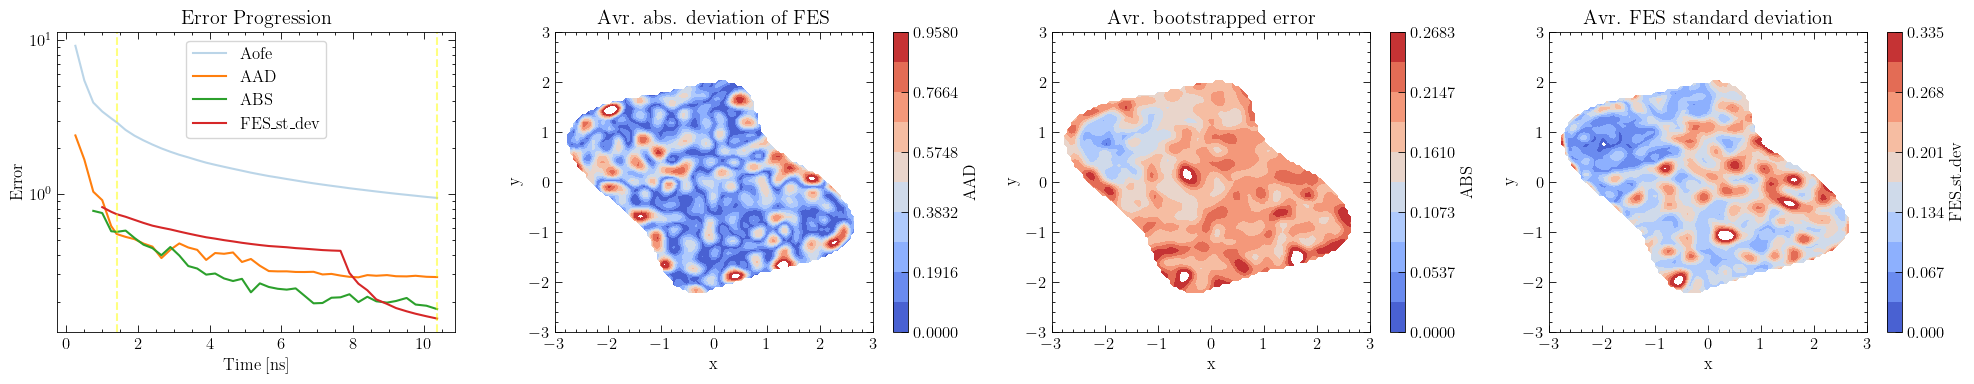

In [67]:
### Plot different error progreesions and maps    
lib2.plot_multiple_error_prog_and_maps(MFI, error_types=["AAD", "ABS", "FES_st_dev"])


Block size 1: sd_fes = 0.1756,  length=41
Block size 3: sd_fes = 0.1860,  length=14
Block size 5: sd_fes = 0.2026,  length=9
Block size 10: sd_fes = 0.2754,  length=5


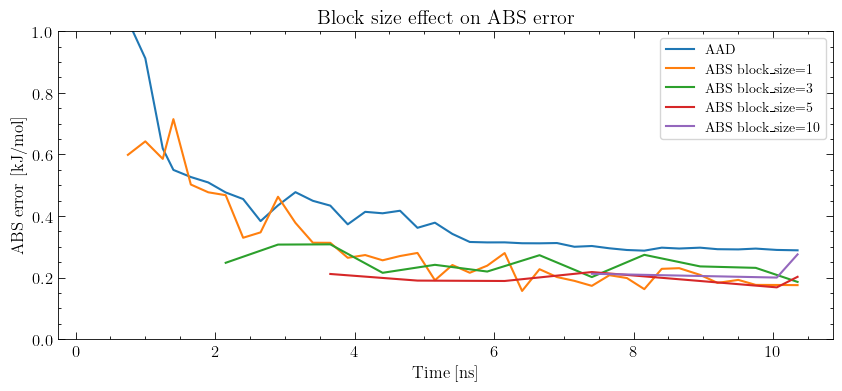

In [68]:
### bootstrap error with increasing BLOCK SIZE
n_bootstrap = 20
plt.figure(figsize=(10,4))
plt.plot(MFI.Avr_Error_list[:,0], MFI.Avr_Error_list[:,MFI.aad_index], label="AAD")

for block_size in [1, 3, 5, 10]:
    _, _, _, sd_fes_evo_bs, time_bs = lib2.bootstrapping_progression(X,Y,MFI.forces_e_list, time_array=MFI.Avr_Error_list[:,0], n_bootstrap=n_bootstrap, block_size=block_size, periodic=MFI.periodic, FES_cutoff=MFI.FES_cutoff)
    print(f"Block size {block_size}: sd_fes = {sd_fes_evo_bs[-1]:.4f},  length={len(sd_fes_evo_bs)}")
    plt.plot(time_bs, sd_fes_evo_bs, label=f"ABS block_size={block_size}")

plt.ylim(0, 1); plt.title("Block size effect on ABS error"); plt.xlabel("Time [ns]"); plt.ylabel("ABS error [kJ/mol]"); plt.legend(fontsize=10); plt.show()

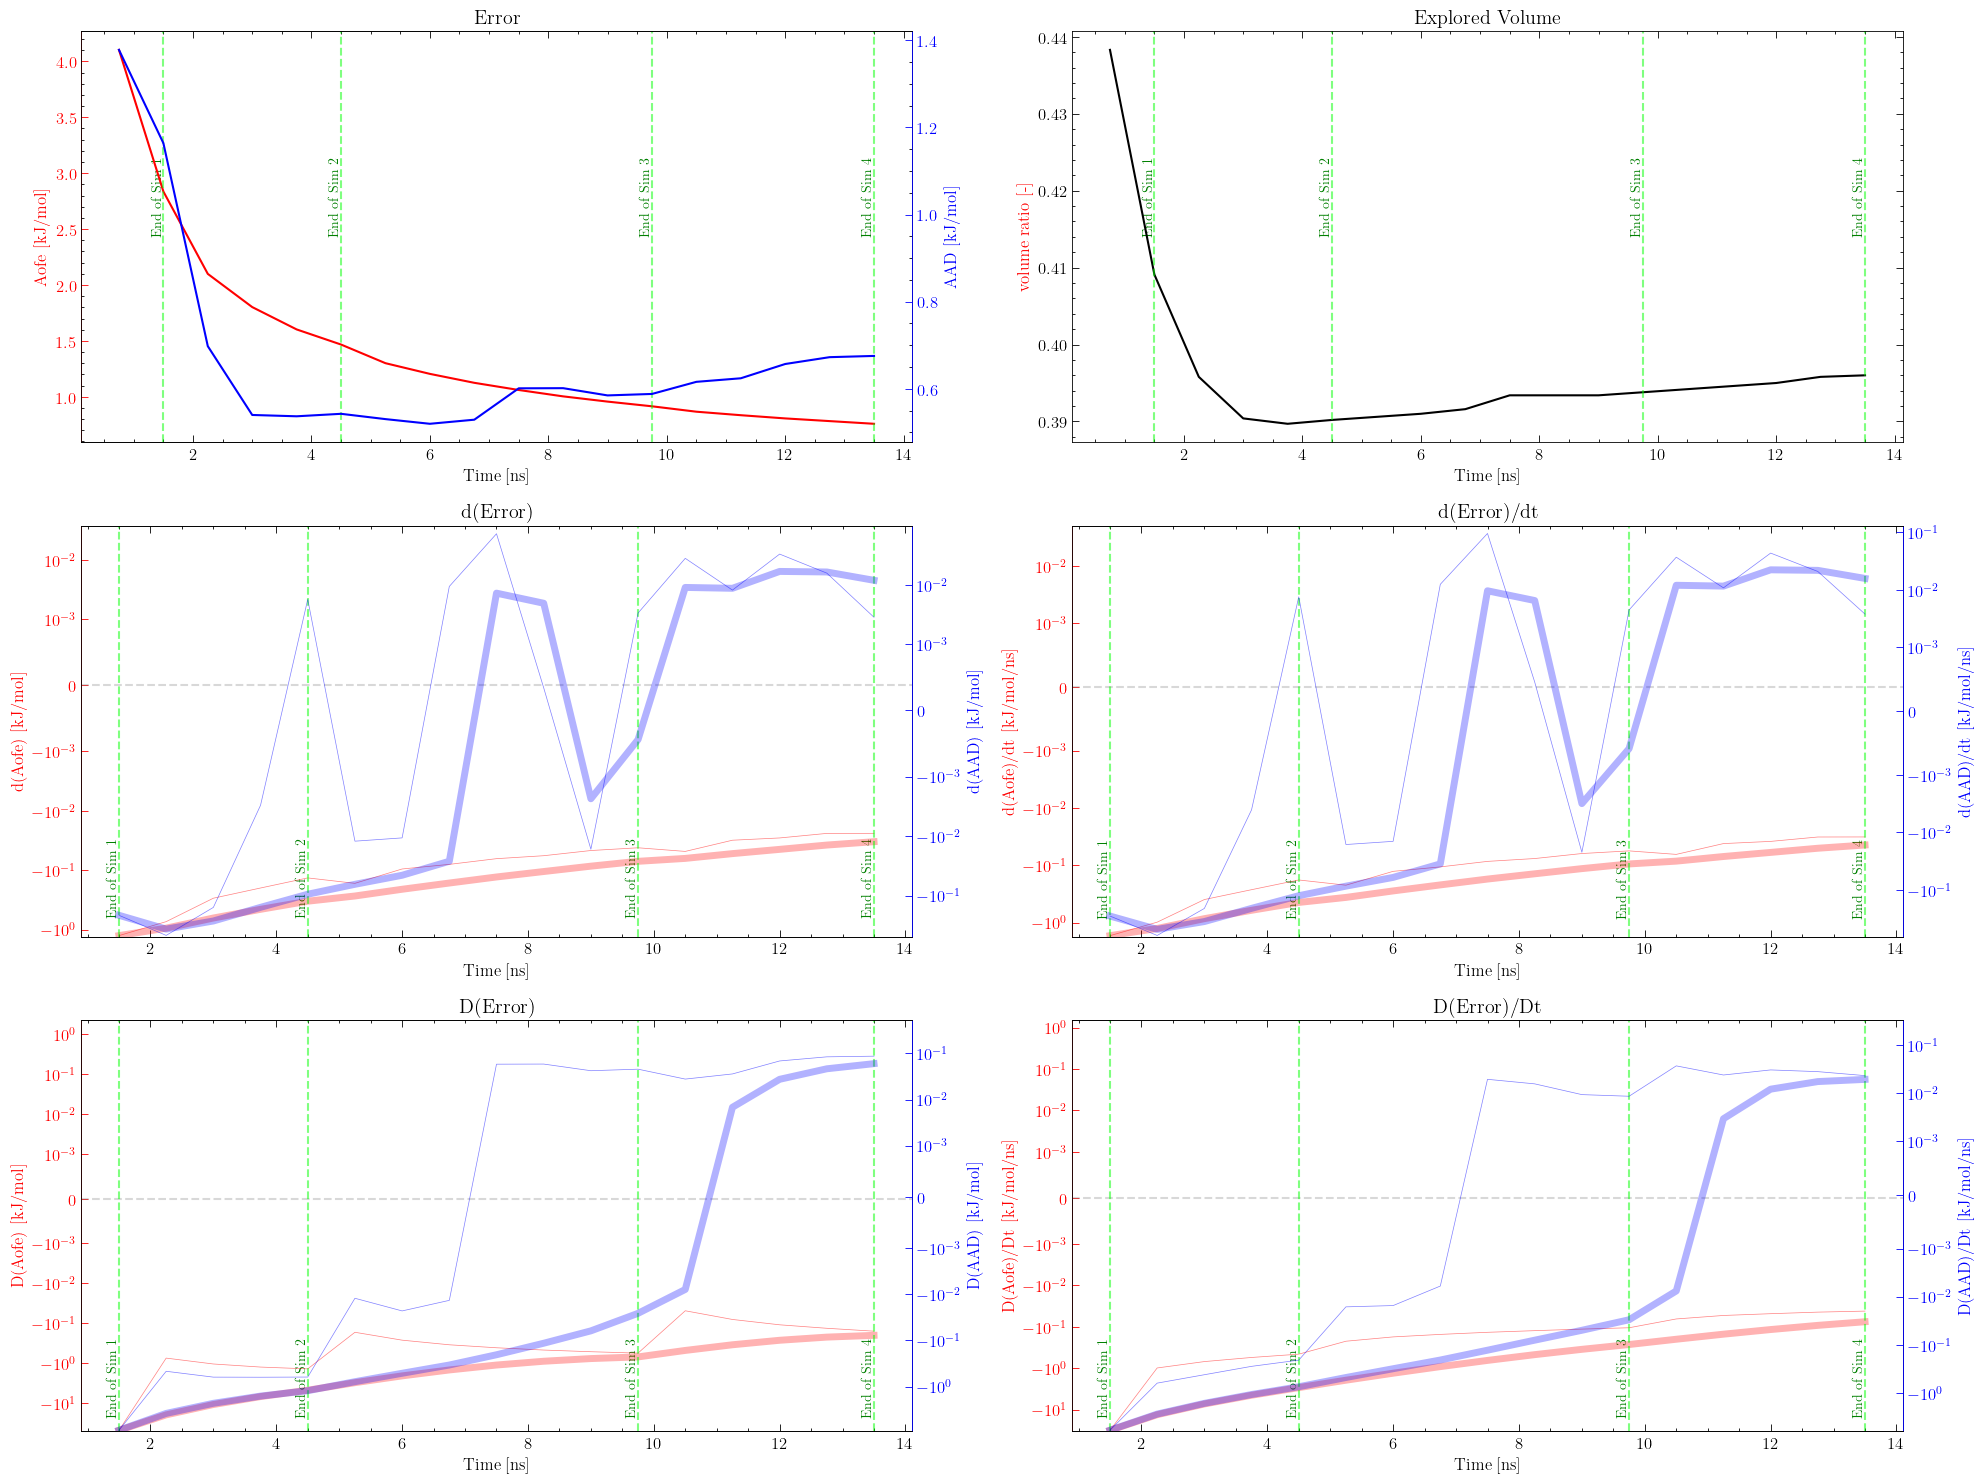

In [8]:
#plot all Error progression    
lib2.plot_all_change_in_error(MFI)

## Alanine Dipeptide

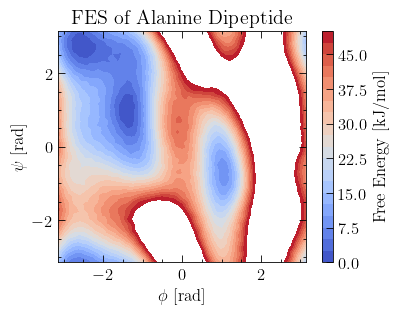

In [16]:
grid = np.linspace(-np.pi, np.pi, 101); 
X, Y = np.meshgrid(grid, grid)
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, periodic=[True, True])

path_AP = path_data + "Alanine_Dipeptide/"
path_input = path_notebook + "/gmx_files/Alanine_Dipeptide/"
plumed_dat_text = f"MOLINFO STRUCTURE={path_input}reference.pdb\nphi: TORSION ATOMS=@phi-2\npsi: TORSION ATOMS=@psi-2\n"

_, _, AP_ref = lib2.load_pkl(path_input + "AP_ref_101x101.pkl")
plt.contourf(X, Y, AP_ref, levels=np.linspace(0, 50, 21), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("$\phi$ [rad]"); plt.ylabel("$\psi$ [rad]"); plt.title("FES of Alanine Dipeptide"); plt.show()

t_compare, v_compare, aofe_compare, aad_compare = lib2.load_pkl(path_input+"AP_10ns_t_v_aofe_aad_prog.pkl")


In [18]:
# default parameters for the MFI class
default_params = {	"X":X, "Y":Y, "Z":AP_ref, "plX":plX, "plY":plY, "periodic":[True, True], "System":"gromacs", "cv_name":["phi","psi"], "plumed_dat_text":plumed_dat_text,
                    "kT":2.49, "time_step":0.001, "simulation_steps":1_000_000, "position_pace":10, "n_pos_per_window":10, 
					"metad_pace":100, "bw":[0.1, 0.1],
         			"len_error_list":50, "FES_cutoff":50.0, # "record_maps":True, "record_forces_e":True, "calculate_FES_st_dev":True, "bootstrap_iter":50,
                    "simulation_folder_path": path_AP, "ID":"",
				  	
                    "find_sim_init_structure":True, "make_tpr_input_file":True, 
					"trajectory_xtc_file_path_list":[path_input+"traj_0.xtc"], "structure_gro_file_path":path_input+"structure.gro", "mdp_file_path":path_input+"gromppvac.mdp", "top_file_path":path_input+"topology.top", "tpr_file_path":path_input+"input.tpr", "pdb_file_path":path_input+"reference.pdb",
           			}


In [8]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2); pass

Loading simulation folder: simulation_test2_1
Loading simulation folder: simulation_test2_2
Loading simulation folder: simulation_test2_3
Loading simulation folder: simulation_test2_4
Loading simulation folder: simulation_test2_5
Loading simulation folder: simulation_test2_6
Loading simulation folder: simulation_test2_7
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test2_8
Loading simulation folder: simulation_test2_9
Loading simulation folder: simulation_test2_10
Loading simulation folder: simulation_test2_11
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test2_12

Restarted SRTR campaign with 12 existing simulations and 2.2027 ns existing simulation time.
Aofe = 2.375 | AAD = 2.208 | 
Continuing with phase: metad

~~ S13  START ~~~
~~ S13  PHASE: metad ~~~  | MetaD h= 4.33 , w= [0.1106,0.14707] , bf= 13 | InvF Bias sf= 1, guas sigma = None | 
S13 | t= 0.01n

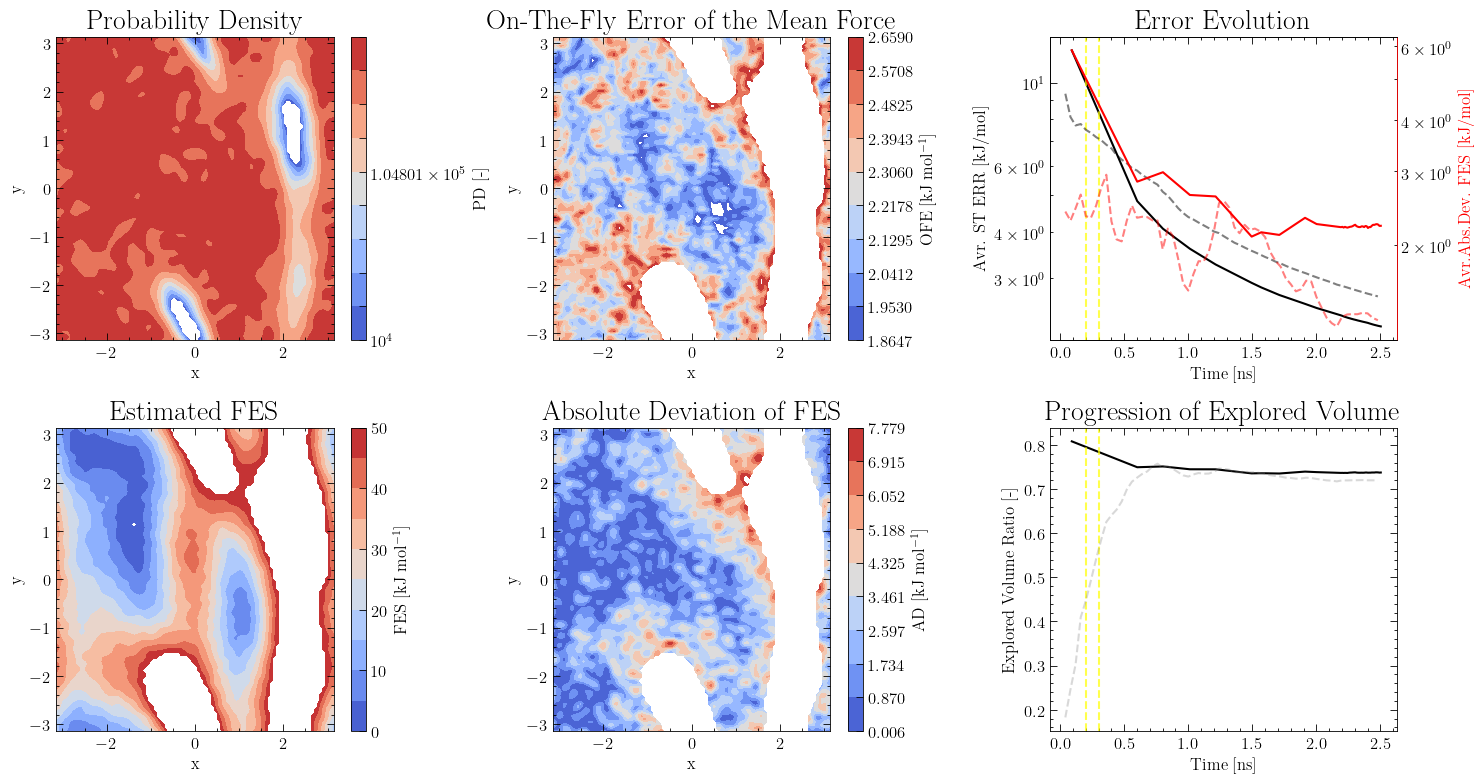


~~~~~~ END ~~~~~~

MFI.Aofe = 2.2255, MFI.AAD = 2.2204


In [22]:
MFI = MFI_class2D.MFI2D(**default_params)

MFI.MFI_real_time_ReInit(ID="_test2", goal=0.1, main_error_type="AAD", n_pos_before_analysis=1000, guaranteed_sim_time=0.2, max_sim_time=0.5,
                        #  time_budget=1)
                         restart_SRTR=True, time_budget=2.5)
                        
MFI.plot_results(t_compare=t_compare, v_compare=v_compare, aofe_compare=aofe_compare, aad_compare=aad_compare)

print(f"\n~~~~~~ END ~~~~~~\n\n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}")


/home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/Alanine_Dipeptide/SRTRcampaign_test2/simulation_test2_13


20080
2008
20080
2008


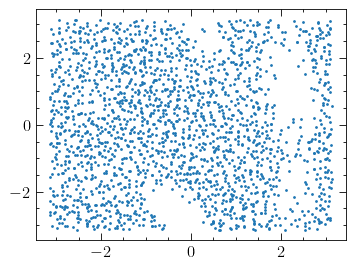

In [30]:
!pwd

os.chdir("/home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/Alanine_Dipeptide/SRTRcampaign_test2/simulation_test2_13")

print(len(MFI.position))
print(len(MFI.hills))

MFI.load_data(hills_file="HILLS_test2_13", position_file="position_test2_13", n_pos_analysed=0)

print(len(MFI.position))
print(len(MFI.hills))

plt.scatter(MFI.hills[:,1], MFI.hills[:,2], s=1); plt.show()

## Run over night

In [34]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2); pass

In [3]:

# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1], #"dZ_dX":dinve_pot_dx, "dZ_dY":dinve_pot_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text, "plX":plX, "plY":plY, "simulation_steps":1_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.186, 0.186], "metad_height":1, "biasfactor":10,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":100,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":50, "record_forces_e":True, "save_error_progression":True,
                    "simulation_folder_path": path_surf, "print_info": False}

SRTR_params = { "goal":0.01, "main_error_type":"AAD", "n_pos_before_analysis":1000, "guaranteed_sim_time":3, "max_sim_time":5, "time_budget":5, "reset_forces_after":"Exploration", "ID":""}

In [5]:
!pwd

/home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/Invernizzi_Potential/SRTRcampaign_1_5ns/simulation_1_5ns_2


In [90]:
tb = SRTR_params["time_budget"]

for n_campaign in range(1,21):
    
    campaign_id = f"_{n_campaign}_{tb}ns"
    path_campaign = path_surf + f"SRTRcampaign{campaign_id}/"
    if not os.path.isdir(path_campaign): os.mkdir(path_campaign)
    os.chdir(path_campaign)
    print(f"\n--- {n_campaign = }, with {campaign_id = }", end=" ")
    
    if os.path.isfile(path_campaign+f"error_progression{campaign_id}.pkl"): 
        print("Results file exists, skipping campaign"); 
        continue
    else: print("--------")
    
    MFI = MFI_class2D.MFI2D(**default_params)        
    SRTR_params.update({"ID":campaign_id})
    
    # try:
    MFI.MFI_real_time_ReInit(**SRTR_params)
    print(f"~~~ End of campaign: Aofe={MFI.Aofe:.4f}, AAD={MFI.AAD:.4f}, ABS={MFI.ABS_error:.4f}")
    # except: print(f"\n~~~~~~~~~~~~ Error in campaign (needs to be repeated) ~~~~~~~~~~~~\n\n\n")

        


--- n_campaign = 1, with campaign_id = '_1_5ns' Results file exists, skipping campaign

--- n_campaign = 2, with campaign_id = '_2_5ns' Results file exists, skipping campaign

--- n_campaign = 3, with campaign_id = '_3_5ns' Results file exists, skipping campaign

--- n_campaign = 4, with campaign_id = '_4_5ns' Results file exists, skipping campaign

--- n_campaign = 5, with campaign_id = '_5_5ns' Results file exists, skipping campaign

--- n_campaign = 6, with campaign_id = '_6_5ns' Results file exists, skipping campaign

--- n_campaign = 7, with campaign_id = '_7_5ns' Results file exists, skipping campaign

--- n_campaign = 8, with campaign_id = '_8_5ns' Results file exists, skipping campaign

--- n_campaign = 9, with campaign_id = '_9_5ns' Results file exists, skipping campaign

--- n_campaign = 10, with campaign_id = '_10_5ns' Results file exists, skipping campaign

--- n_campaign = 11, with campaign_id = '_11_5ns' Results file exists, skipping campaign

--- n_campaign = 12, with c

In [3]:

grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
inve_pot_string = "1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598"
plumed_dat_text_inve = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({inve_pot_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
path_inve = path_data + "Invernizzi_Potential/"
sim_var_inve = 1_000_000, 0.186, 1, 10, 20

pot1 = 3.9*X**4 + 3.9*Y**4 - 19.2*X**2 - 19.2*Y**2 + 5.7*X**3*Y - 5.7*X*Y**3 + 12*X**2*Y**2 - 6*X*Y + 2.7*Y + 3.6*X
pot1 = pot1 - np.min(pot1)
pot1_string = "3.9*x^4+3.9*y^4-19.2*x^2-19.2*y^2+5.7*x^3*y-5.7*x*y^3+12*x^2*y^2-6*x*y+2.7*y+3.6*x"
plumed_dat_text_pot1 = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot1_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
path_pot1 = path_data + "pot1/"
sim_var_pot1 = 1_500_000, 0.1, 2, 20, 40

pot2 = 1.84*X**6 + 1.84*Y**6 - 11.5*X**4 - 11.5*Y**4 + 17.94*X**2 + 17.94*Y**2 - 2.3*X**5*Y + 2.3*X*Y**5 - 3.7*X**3*Y + 3.7*X*Y**3 + 20*X**2*Y**2 + 2.1*X**2 + 2.1*Y**2 + X**2*Y + X*Y**2 + 24.70075155
pot2 = pot2 - np.min(pot2)
pot2_string = "1.84*x^6+1.84*y^6-11.5*x^4-11.5*y^4+17.94*x^2+17.94*y^2-2.3*x^5*y+2.3*x*y^5-3.7*x^3*y+3.7*x*y^3+20*x^2*y^2+2.1*x^2+2.1*y^2+x^2*y+x*y^2+24.70075155"
plumed_dat_text_pot2 = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot2_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
path_pot2 = path_data + "pot2/"
sim_var_pot2 = 3_000_000, 0.1, 2, 20, 40

pot3 = np.exp(X-2)**5 + np.exp(-X-2)**5 + np.exp(Y-2)**5 + np.exp(-Y-2)**5 + 13*np.sin(2*X*Y) + 17*np.sin(2*Y) + 0.137*X**4*Y**4
pot3 = pot3 - np.min(pot3)
pot3_string = "exp(x-2)^5+exp(-x-2)^5+exp(y-2)^5+exp(-y-2)^5+13*sin(2*x*y)+17*sin(2*y)+0.137*x^4*y^4"
plumed_dat_text_pot3 = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot3_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
path_pot3 = path_data + "pot3/"
sim_var_pot3 = 3_000_000, 0.1, 2, 20, 40

pot_list = [inve_pot, pot1, pot2, pot3]
pot_string_list = [inve_pot_string, pot1_string, pot2_string, pot3_string]
plumed_dat_text_list = [plumed_dat_text_inve, plumed_dat_text_pot1, plumed_dat_text_pot2, plumed_dat_text_pot3]
path_list = [path_inve, path_pot1, path_pot2, path_pot3]
sim_var_list = [sim_var_inve, sim_var_pot1, sim_var_pot2, sim_var_pot3]

# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1], #"dZ_dX":dinve_pot_dx, "dZ_dY":dinve_pot_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text_inve, "plX":plX, "plY":plY, "simulation_steps":1_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":None, "metad_height":None, "biasfactor":None,
                    "Bias_sf":1.02, "gaus_filter_sigma":2,
                    "len_error_list":100, "FES_cutoff":20, "bootstrap_iter":50, "save_error_progression":True,
                    "simulation_folder_path": path_inve, "print_info": False}

SRTR_params = { "goal":0.01, "main_error_type":"AAD", "n_pos_before_analysis":1000, "guaranteed_sim_time":3, "max_sim_time":5, "time_budget":5, "reset_forces_after":"Exploration", "ID":""}

In [10]:
tb = SRTR_params["time_budget"]

for n_campaign in range(1,100):
# for n_campaign in range(1,42):
    
    for n_pot in range(4):
    # for n_pot in [0]:
        
        sim_var = sim_var_list[n_pot]
        tb = sim_var[0] / 200_000
        path_surf = path_list[n_pot]

        campaign_id = f"_{n_campaign}_{int(tb)}ns"
        path_campaign = path_surf + f"SRTRcampaign{campaign_id}/"
        if not os.path.isdir(path_campaign): os.mkdir(path_campaign)
        os.chdir(path_campaign)
        # print(f"\n--- {n_campaign = }, Surf: {n_pot}", end=" ")

    
        if os.path.isfile(path_campaign+f"error_progression{campaign_id}.pkl"): 
            error = lib2.load_pkl(path_campaign+f"error_progression{campaign_id}.pkl")
            if error[3][-1] > 2.5: print(f"S{n_pot}: {n_campaign = }, AAD={error[3][-1]:.4f}, {error.shape = }");
            # print()
            # print(f"~~~ Results exists: Aofe={error[2,-1]:.4f}, AAD={error[3, -1]:.4f}, ABS={error[4,-1]:.4f}")
            continue
        else: print("--------")
        
        new_params = default_params.copy()
        new_params.update({"ID":campaign_id, "Z":pot_list[n_pot], "plumed_dat_text":plumed_dat_text_list[n_pot], "simulation_folder_path": path_surf, "FES_cutoff":sim_var[4]})
                        #    "metad_width":[sim_var[1], sim_var[1]], "metad_height":sim_var[2], "biasfactor":sim_var[3],
        new_srtr_params = SRTR_params.copy()
        new_srtr_params.update({"ID":campaign_id, "time_budget":tb, "guaranteed_sim_time":int(np.ceil(tb/2)), "max_sim_time":tb})

        MFI = MFI_class2D.MFI2D(**new_params)        
        
        try:
            MFI.MFI_real_time_ReInit(**new_srtr_params)
            print(f"~~~ End of campaign: Aofe={MFI.Aofe:.4f}, AAD={MFI.AAD:.4f}, ABS={MFI.ABS_error:.4f}")
        except: print(f"\n~~~~~~~~~~~~ Error in campaign (needs to be repeated) ~~~~~~~~~~~~\n\n\n")

        

S2: n_campaign = 15, AAD=2.6530, error.shape = (5, 73)
S2: n_campaign = 23, AAD=2.8854, error.shape = (5, 73)
S2: n_campaign = 26, AAD=2.5432, error.shape = (5, 74)
S2: n_campaign = 32, AAD=2.5642, error.shape = (5, 73)
S2: n_campaign = 42, AAD=2.6334, error.shape = (5, 64)
S2: n_campaign = 43, AAD=2.7537, error.shape = (5, 64)
S2: n_campaign = 45, AAD=2.6171, error.shape = (5, 67)
S2: n_campaign = 46, AAD=2.5830, error.shape = (5, 66)
S2: n_campaign = 47, AAD=3.0196, error.shape = (5, 66)
S2: n_campaign = 50, AAD=2.5794, error.shape = (5, 67)
S2: n_campaign = 52, AAD=2.8161, error.shape = (5, 66)
S2: n_campaign = 55, AAD=2.5440, error.shape = (5, 73)
S2: n_campaign = 56, AAD=2.7912, error.shape = (5, 71)
S2: n_campaign = 59, AAD=2.9210, error.shape = (5, 72)
S2: n_campaign = 60, AAD=2.8424, error.shape = (5, 71)
S2: n_campaign = 64, AAD=2.9033, error.shape = (5, 72)
S2: n_campaign = 67, AAD=2.9434, error.shape = (5, 72)
S2: n_campaign = 69, AAD=2.5526, error.shape = (5, 72)
S2: n_camp

In [79]:
print(MFI.gaus_filter_sigma)

None


(5, 28)


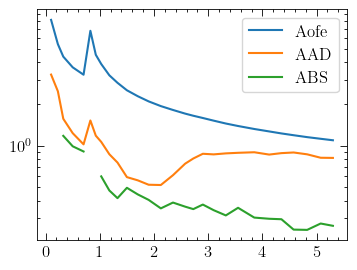

In [77]:
# error = MFI.Avr_Error_list.T

print(error.shape)

plt.plot(error[0], error[2], label="Aofe")
plt.plot(error[0], error[3], label="AAD")
plt.plot(error[0], error[4], label="ABS")
plt.legend()
plt.yscale("log")

### Calculate and plot average error progression

t=[0.25,30.05] | Final avr: AOFE=0.495, AAD=0.583


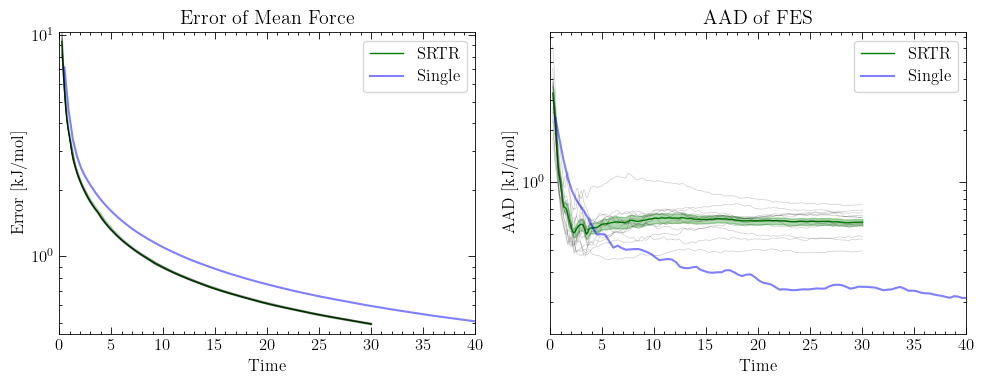

In [19]:
total_campaigns = 13
time_budget = 30

lib2.get_avr_error_prog(path_data=path_invernizzi, total_campaigns=total_campaigns, time_budget=time_budget, include_aad=True, simulation_type="SRTR", show_plot=False, line_label="SRTR")

[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib2.load_pkl(path_notebook + "/error_progressions/error_progression_long_inve.pkl")
plt.subplot(1,2,1); plt.plot(time_l, ofe_mean_l, label="Single", color="blue", alpha=0.5); plt.legend(); plt.xlim(0, 40); 
plt.subplot(1,2,2); plt.plot(time_l, aad_mean_l, label="Single", color="blue", alpha=0.5); plt.legend(); plt.xlim(0, 40); 
plt.tight_layout(); plt.show()